In [15]:
import os
import re
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import tqdm
from typing import Optional
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
imageDir = 'Images'
dataDir = 'list_attribute.csv'
data = pd.read_csv(dataDir, sep=';')
data = data.drop(data.columns.difference(['id', 'Male']), axis=1)
data['Male'] = data['Male'].replace(-1, 0)
data = data[~data['id'].str.contains(r'\(.*\)')]

In [17]:
data

,id,Male
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,1
3,000004.jpg,0
4,000005.jpg,0
...,...,...
202594,202595.jpg,0
202595,202596.jpg,1
202596,202597.jpg,1
202597,202598.jpg,0


In [18]:
cleanedData = pd.read_csv('imageNtarget.csv')
cleanedData

,imageId,target
0,185029.jpg,1
1,154445.jpg,1
2,081551.jpg,1
3,184097.jpg,0
4,081330.jpg,1
...,...,...
4995,038684.jpg,0
4996,051742.jpg,1
4997,091853.jpg,0
4998,061556.jpg,1


In [19]:
def imshow(img):
    image = img.numpy().transpose((1,2,0))
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.pause(.001)

In [20]:
class customDataset(Dataset):
    def __init__(self, imageDir, dataframe, transform=None):
        self.imageDir = imageDir
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.imageDir, img_id)
        image = Image.open(img_path).convert('RGB')
        target = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, target


In [21]:
class dataModule(pl.LightningDataModule):
    def __init__(self, trainRatio, valRatio, batchSize=32, imgDir=imageDir, targetDataframe=cleanedData):
        super().__init__()
        self.batchSize = batchSize
        self.imgDir = imgDir
        self.trainRatio = trainRatio
        self.valRatio = valRatio
        self.targetDataframe = targetDataframe
        self.classes = targetDataframe['target'].unique()
    def prepare_data(self):
        pass
    def setup(self, stage):
        transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        fullDataset = customDataset(self.imgDir, self.targetDataframe, transform=transform)
        trainSize = int(self.trainRatio * len(fullDataset))
        valSize = int(self.valRatio * len(fullDataset))
        predSize = int(len(fullDataset) - trainSize - valSize)
        self.trainSet, self.valSet, self.predSet = random_split(fullDataset, [trainSize, valSize, predSize])
        # print(len(fullDataset))
    def train_dataloader(self):
        trainSet = DataLoader(self.trainSet, batch_size=self.batchSize, shuffle=True, num_workers=8, drop_last=True)
        return trainSet
    def val_dataloader(self):
        valSet = DataLoader(self.valSet, batch_size=self.batchSize, shuffle=False, num_workers=8, drop_last=True)
        return valSet
    def predict_dataloader(self):
        predSet = DataLoader(self.predSet, batch_size=self.batchSize, shuffle=True, num_workers=8, drop_last=True)
        return predSet

In [54]:
class resnet50TL(pl.LightningModule):
    def __init__(self, lr, decay=0):
        super().__init__()
        # self.classOutput = classOutput
        # freezing the conv layer (feature extractor) and use the extracted feature to train the fc layer
        backbone = models.resnet50(weights='IMAGENET1K_V2')
        inFeatures = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.featureExtractor = nn.Sequential(*layers)
        self.classifier = nn.Linear(inFeatures, 1)
        self.lossFn = nn.BCEWithLogitsLoss()
        self.accuracy = torchmetrics.classification.BinaryAccuracy(threshold=0.5)
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.lr = lr
        self.decay=decay
        self.unnormalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(self.mean, self.std)], std=[1/s for s in self.std]
        )
    def forward(self, x):
        self.featureExtractor.eval()
        with torch.no_grad():
            logits = self.featureExtractor(x).flatten(1)
        # x = self.featureExtractor(x).flatten(1)
        x = self.classifier(logits)
        return x
    
    def training_step(self, batch, batch_idx):
        img, target = batch
        # img = img.view(img.size(0), -1)
        logits = self.forward(img)
        target = target.unsqueeze(1).float()
        loss = self.lossFn(logits, target)
        accuracy = self.accuracy(logits, target)
        self.log_dict({'training_accuracy' : accuracy, 'training_loss' : loss}, on_step=False, on_epoch=True, prog_bar=True)
        if batch_idx % 5 == 0:
            imgLog = img[:8]
            grid = torchvision.utils.make_grid(self.unnormalize(imgLog))
            self.logger.experiment.add_image('artist images', grid, self.global_step)
        return loss
    
    def validation_step(self, batch, batch_idx):
        img, target = batch
        # img = img.view(img.size(0), -1)
        logits = self.forward(img)
        target = target.unsqueeze(1).float()
        loss = self.lossFn(logits, target)
        accuracy = self.accuracy(logits, target)
        self.log_dict({'validation_accuracy' : accuracy, 'validation_loss' : loss}, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def predict_step(self, batch, batch_idx):
        img, target = batch
        # img = img.view(img.size(0), -1)
        logits = self.forward(img)
        target = target.unsqueeze(1).float()
        sigmoid = nn.Sigmoid()
        probs = sigmoid(logits)
        thresh = 0.5
        preds = (probs >= thresh).float()
        accuracy = self.accuracy(logits, target)
        self.print(f'prediction accuracy was {accuracy:.4f}')
        # self.log('prediction_accuracy', accuracy, on_step=False, on_epoch=True, prog_bar=True)
        self.unnormalize(img)
        return img, target, preds, probs
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.decay)
        

In [55]:
logger = TensorBoardLogger('tensorB_logs', name='face_recognition_resnet50_transfer_learning')
dataMod = dataModule(0.8, 0.1)
model = resnet50TL(0.001, 0.0001)
trainer = pl.Trainer(accelerator='gpu', devices=[0], min_epochs=1, max_epochs=50, precision=32, logger=logger, default_root_dir='ckpt/')
# print(dataMod)
tuner = pl.tuner.Tuner(trainer)
tuner.lr_find(model, datamodule=dataMod)
trainer.fit(model=model, datamodule=dataMod)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.012022644346174132
Restoring states from the checkpoint path at ckpt/.lr_find_ca42a379-53b3-4a0c-b5d2-854b9605f2bc.ckpt
Restored all states from the checkpoint at ckpt/.lr_find_ca42a379-53b3-4a0c-b5d2-854b9605f2bc.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type              | Params
-------------------------------------------------------
0 | featureExtractor | Sequential        | 23.5 M
1 | classifier       | Linear            | 2.0 K 
2 | lossFn           | BCEWithLogitsLoss | 0     
3 | accuracy         | BinaryAccuracy    | 0     
4 | unnormalize      | Normalize         | 0     
-------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.040    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [147]:
trainer.save_checkpoint('/notebooks/ckpt/model.ckpt')

In [56]:
# model = resnet50TL.load_from_checkpoint('ckpt/model.ckpt')
# trainer = pl.Trainer()
preds = trainer.predict(model, datamodule=dataMod)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

prediction accuracy was 1.0000
prediction accuracy was 1.0000
prediction accuracy was 1.0000
prediction accuracy was 0.9375
prediction accuracy was 0.9688
prediction accuracy was 1.0000
prediction accuracy was 0.9688
prediction accuracy was 1.0000
prediction accuracy was 1.0000
prediction accuracy was 1.0000
prediction accuracy was 0.9688
prediction accuracy was 1.0000
prediction accuracy was 1.0000
prediction accuracy was 0.9375
prediction accuracy was 1.0000
prediction accuracy was 1.0000


In [57]:
def invNormalize(img):
    image = img.numpy().transpose((1,2,0))
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

def visPreds(predictionList, out):
    plt.figure(figsize=(10,11))
    className = ['Female', 'Male']
    arr = np.array(predictionList)
    arrImage = arr[0][0]
    arrTarget = arr[0][1]
    arrPreds = arr[0][2]
    arrProbs = arr[0][3]
    for k in range(out):
        ax = plt.subplot(3, 3, k+1)
        plt.title(f'Real class {className[int(arrTarget[k])]}\nPredicted class {className[int(arrPreds[k])]}\nPrediction confidence {float(arrProbs[k]):.2f}')
        plt.axis('off')
        plt.imshow(invNormalize(arrImage[k]))

def visFalsePreds(predictionList):
    plt.figure(figsize=(15, 15))
    className = ['Female', 'Male']
    arr = np.array(predictionList)
    imagesArr = arr[:, 0]
    targetArr = arr[:, 1]
    predsArr = arr[:, 2]
    probsArr = arr[:, 3]
    imagesList = [images for batch in imagesArr for images in batch]
    targetList = [target for batch in targetArr for target in batch]
    predsList = [preds for batch in predsArr for preds in batch]
    probsList = [probs for batch in probsArr for probs in batch]
    falsePreds = [i for i, (target, pred) in enumerate(zip(targetList, predsList)) if target != pred]
    if not falsePreds:
        print('No false prediction')
    else:
        print(falsePreds)
        numFalse = len(falsePreds)
        for i, falseIndex in enumerate(falsePreds):
            ax = plt.subplot(3, 3, i+1)
            plt.title(f'Real class {className[int(targetList[falseIndex])]}\nPredicted class {className[int(predsList[falseIndex])]}\nPrediction confidence {float(probsList[falseIndex]):2f}')
            plt.axis('off')
            plt.imshow(invNormalize(imagesList[falseIndex]))

Layer 1


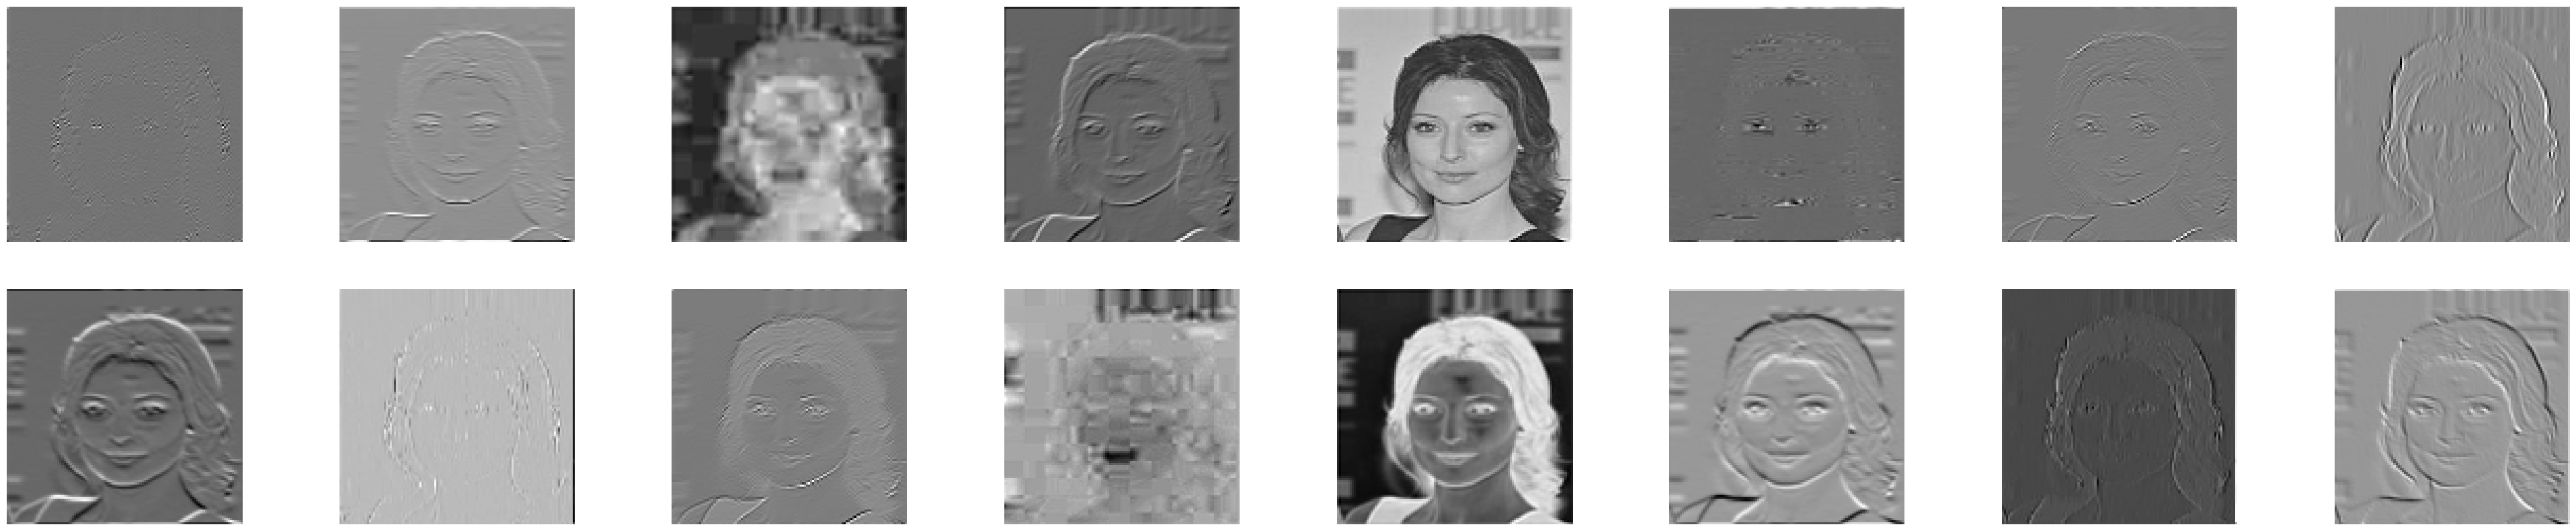

In [58]:
loadIter = iter(dataMod.train_dataloader())
img, targ = loadIter.next()
imgSample = img[0].unsqueeze(0)
layers = list(model.featureExtractor.children())
convLayers = []
numConv = 0
for child in layers:
    if type(child) == nn.Conv2d:
        numConv +=1
        convLayers.append(child)
    elif type(child)==nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                numConv += 1
                convLayers.append(layer)
                
results = [convLayers[0](imgSample)]
for i in range(1, len(convLayers)):
    results.append(convLayers[i](results[-1]))
outputs = results
for numLayer in range(len(outputs)):
    plt.figure(figsize=(50,10))
    layerVis = outputs[numLayer][0,:,:,:]
    layerVis = layerVis.data
    print("Layer", numLayer+1)
    for i, filter in enumerate(layerVis):
        if i == 16:
            break
        plt.subplot(2, 8, i+1)
        plt.imshow(filter, cmap='gray')
        plt.axis('off')
    plt.show()
    plt.close()

/tmp/ipykernel_1285/2636156739.py:11: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(predictionList)
/tmp/ipykernel_1285/2636156739.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(predictionList)


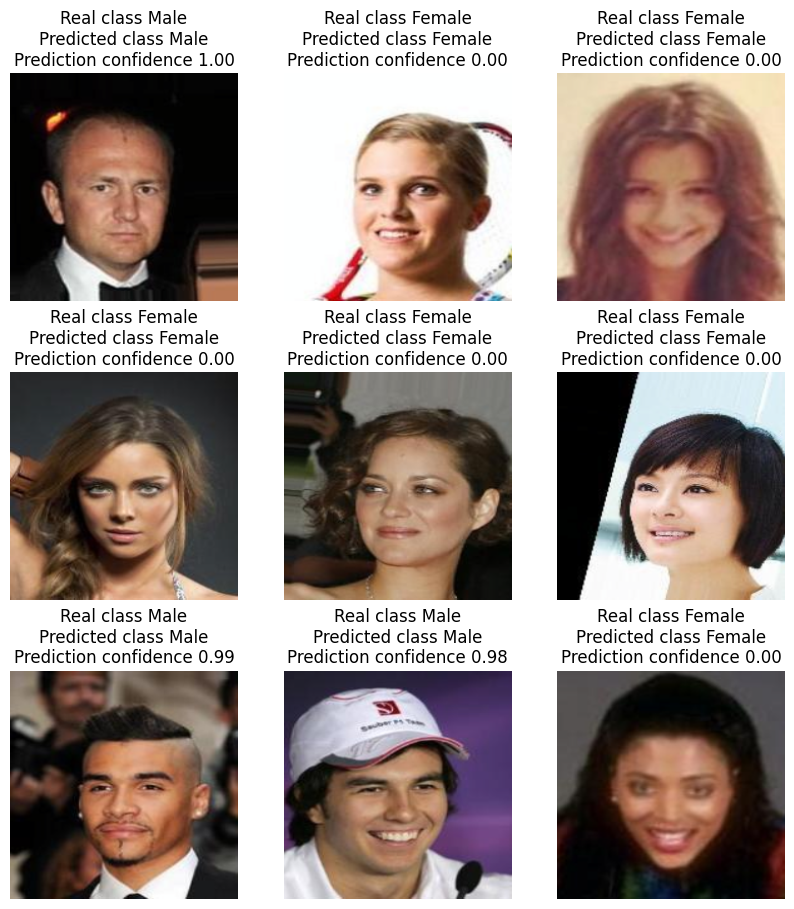

In [59]:
visPreds(preds, 9)

/tmp/ipykernel_1285/2636156739.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(predictionList)
/tmp/ipykernel_1285/2636156739.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(predictionList)


[102, 111, 143, 196, 346, 437, 442]


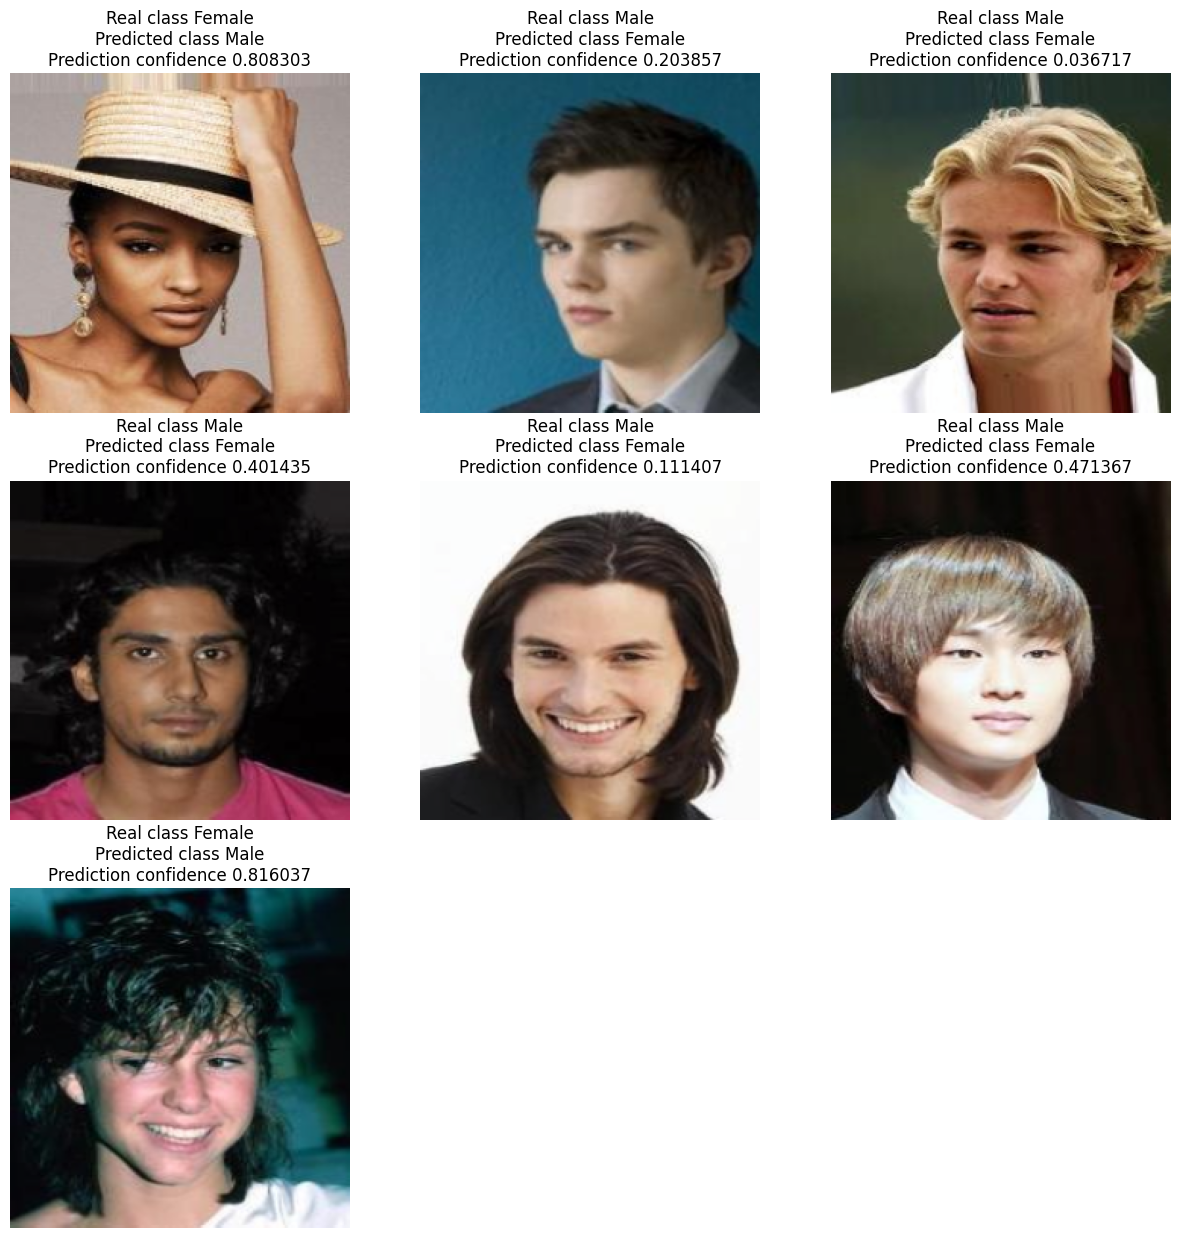

In [60]:
visFalsePreds(preds)